Enter the stock tickers (comma-separated): AAPL, MSFT, META
Enter the initial investment amounts (comma-separated): 1000, 2000, 250
Enter the number of days: 10
Enter the confidence level (e.g., 0.95 for 95%): .95
[*********************100%%**********************]  3 of 3 completed

Portfolio Value at Risk (VaR) using Variance-Covariance method at 95.00% confidence level is:
9.05%
$294.05



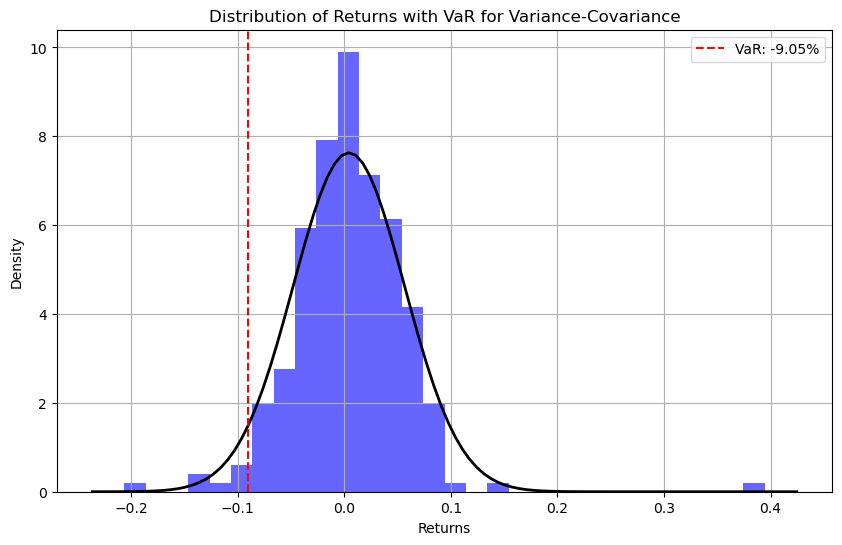

Portfolio Historical Value at Risk (VaR) at 95.00% confidence level is:
7.55%
$245.40



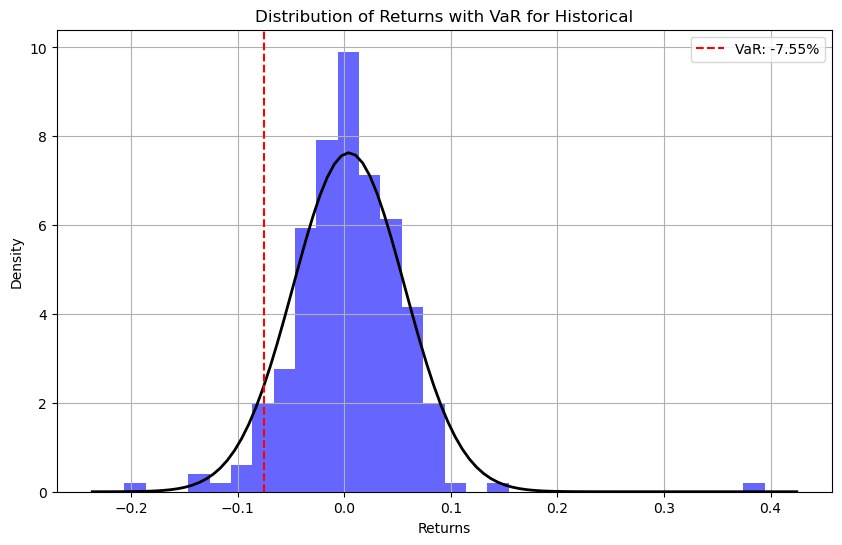

Portfolio Monte Carlo Value at Risk (VaR) at 95.00% confidence level is:
7.44%
$241.66


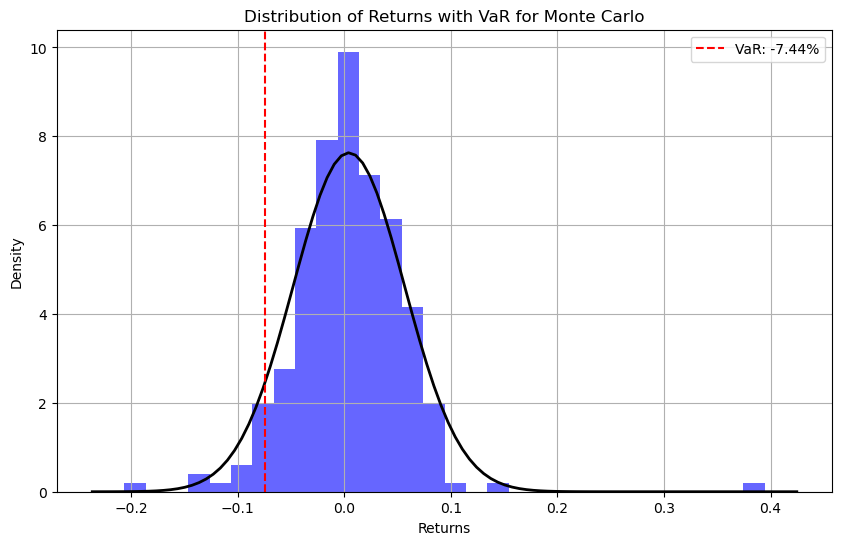

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Fetch historical stock data for multiple tickers
def fetch_stock_data(tickers):
    stock_data = yf.download(tickers, period="1y")['Close']
    return stock_data

# Function to calculate VaR using Variance-Covariance method for a portfolio
def calculate_varcov(returns, weights, days, confidence_level):
    portfolio_returns = (returns * weights).sum(axis=1)

    mean_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()

    z_score = norm.ppf(1 - confidence_level)

    var = (mean_return - z_score * std_return) * np.sqrt(days)
    var_percent = var * 100
    var_value = var * portfolio_value

    return var_percent, var_value, portfolio_returns

# Function to calculate Historical Value at Risk for a portfolio
def calculate_historical_var(returns, weights, days, confidence_level):
    portfolio_returns = (returns * weights).sum(axis=1)
    sorted_returns = np.sort(portfolio_returns)

    var_index = int((1 - confidence_level) * len(sorted_returns))

    var_value = sorted_returns[var_index] * np.sqrt(days)
    var_percent = -var_value * 100
    var_dollar_value = -var_value * portfolio_value

    return var_percent, var_dollar_value, portfolio_returns

# Function to calculate Monte Carlo Value at Risk for a portfolio
def calculate_monte_carlo_var(returns, weights, days, confidence_level, simulations=10000):
    portfolio_returns = (returns * weights).sum(axis=1)
    mean_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()

    simulated_returns = np.random.normal(mean_return, std_return, (days, simulations))

    simulated_price_paths = np.exp(simulated_returns.cumsum(axis=0))
    last_price = portfolio_value  # Use the total portfolio value
    simulated_end_prices = last_price * simulated_price_paths[-1]

    simulated_returns = (simulated_end_prices - last_price) / last_price
    sorted_simulated_returns = np.sort(simulated_returns)

    var_index = int((1 - confidence_level) * simulations)
    var_value = sorted_simulated_returns[var_index]

    var_percent = -var_value * 100
    var_dollar_value = -var_value * portfolio_value

    return var_percent, var_dollar_value, portfolio_returns

# Plotting the distribution of returns and VaR
def plot_var_distribution(returns, var_value, var_label):
    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=30, alpha=0.6, color='blue', density=True)

    # Fit a normal distribution to the data
    mu, std = norm.fit(returns)

    # Plot the PDF of the fitted distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    # Plot the VaR line
    plt.axvline(var_value, color='red', linestyle='--', label=f'VaR: {var_value:.2%}')

    plt.title(f'Distribution of Returns with VaR for {var_label}')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

# Get user input for portfolio
def get_user_input():
    tickers = input("Enter the stock tickers (comma-separated): ").split(',')
    tickers = [ticker.strip().upper() for ticker in tickers]  # Clean up the tickers
    initial_investments = input("Enter the initial investment amounts (comma-separated): ").split(',')
    initial_investments = [float(amount.strip()) for amount in initial_investments]  # Clean up the amounts

    # Get user input for days and confidence level
    days = int(input("Enter the number of days: "))
    confidence_level = float(input("Enter the confidence level (e.g., 0.95 for 95%): "))

    return tickers, initial_investments, days, confidence_level

def main():
    tickers, initial_investments, days, confidence_level = get_user_input()

    # Fetch historical data once for the portfolio
    stock_data = fetch_stock_data(tickers)

    # Calculate daily returns
    returns = stock_data.pct_change().dropna()

    # Calculate total portfolio value
    global portfolio_value
    portfolio_value = sum(initial_investments)

    # Calculate weights for each stock in the portfolio
    weights = np.array(initial_investments) / portfolio_value

    # Calculate and display VaR using Variance-Covariance method
    var_percent, var_value, portfolio_returns_varcov = calculate_varcov(returns, weights, days, confidence_level)
    print(f"\nPortfolio Value at Risk (VaR) using the Variance-Covariance method at {confidence_level*100:.2f}% confidence level is:")
    print(f"{var_percent:.2f}%")
    print(f"${var_value:.2f}\n")

    # Plot VaR distribution for Variance-Covariance
    plot_var_distribution(portfolio_returns_varcov * np.sqrt(days), -var_percent/100, 'Variance-Covariance')

    # Calculate and display Historical VaR
    var_percent, var_dollar_value, portfolio_returns_historical = calculate_historical_var(returns, weights, days, confidence_level)
    print(f"Portfolio Historical Value at Risk (VaR) at {confidence_level*100:.2f}% confidence level is:")
    print(f"{var_percent:.2f}%")
    print(f"${var_dollar_value:.2f}\n")

    # Plot VaR distribution for Historical
    plot_var_distribution(portfolio_returns_historical * np.sqrt(days), -var_percent/100, 'Historical')

    # Calculate and display Monte Carlo VaR
    var_percent, var_dollar_value, portfolio_returns_monte_carlo = calculate_monte_carlo_var(returns, weights, days, confidence_level, simulations=1000)
    print(f"Portfolio Monte Carlo Value at Risk (VaR) at {confidence_level*100:.2f}% confidence level is:")
    print(f"{var_percent:.2f}%")
    print(f"${var_dollar_value:.2f}")

    # Plot VaR distribution for Monte Carlo
    plot_var_distribution(portfolio_returns_monte_carlo * np.sqrt(days), -var_percent/100, 'Monte Carlo')

if __name__ == "__main__":
    main()